# Importing libraries and loading data

In [1]:
# import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import shap
import matplotlib.pyplot as plt
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import re

import warnings 
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 1000)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
df0 = pd.read_csv('/kaggle/input/videogamesales/vgsales.csv').drop(['Rank', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', ], axis=1)
print(df0.shape, df0.columns)
df1 = pd.read_csv('/kaggle/input/video-game-sales-2024/vgchartz-2024.csv').drop(['img', 'critic_score', 'na_sales', 'jp_sales', 'pal_sales', 'other_sales', ], axis=1)
df1.rename(columns={'title': 'Name', 
                    'console': 'Platform', 
                    'genre': 'Genre', 
                    'publisher': 'Publisher', 'total_sales': 'Global_Sales'}, inplace=True)
df1['Year'] = pd.to_datetime(df1['release_date']).dt.year
df1 = df1[df0.columns]
print(df1.shape, df1.columns)

(16598, 6) Index(['Name', 'Platform', 'Year', 'Genre', 'Publisher', 'Global_Sales'], dtype='object')
(64016, 6) Index(['Name', 'Platform', 'Year', 'Genre', 'Publisher', 'Global_Sales'], dtype='object')


In [3]:
df0.sample(5).T

,13957,12937,10381,2519,8817
Name,GoPets: Vacation Island,Judge Dredd,Robotics;Notes,Tales of the Abyss,Kowloon's Gate
Platform,DS,PS,PS3,3DS,PS
Year,2008.0,1997.0,2012.0,2011.0,1997.0
Genre,Simulation,Platform,Adventure,Role-Playing,Adventure
Publisher,Konami Digital Entertainment,Gremlin Interactive Ltd,5pb,Namco Bandai Games,Sony Computer Entertainment
Global_Sales,0.04,0.05,0.11,0.82,0.15


In [4]:
df1.sample(5).T

,39046,10364,24234,63692,56471
Name,Wiki Read: Wikipedia for Xbox,America's Next Top Model,River City: Rival Showdown,"Warhammer 40,000: Chaos Gate – Daemonhunters",Darklight Conflict
Platform,XBL,DS,3DS,XOne,SAT
Year,2011.0,2010.0,2017.0,NaN,1997.0
Genre,Misc,Simulation,Action,Strategy,Simulation
Publisher,Microsoft,Conspiracy Entertainment,Natsume,Unknown,Electronic Arts
Global_Sales,NaN,0.1,NaN,NaN,NaN


In [5]:
df = pd.concat([df0, df1]).drop_duplicates()
print(df.shape)
df.sample(5).T

(74932, 6)


,28082,60566,56491,10700,40716
Name,Cosmonious High,Break in,Densha de Go! Final,Murder in Venice,Doom Troopers
Platform,PC,WiiU,PS2,DS,SNES
Year,NaN,NaN,2004.0,2011.0,1995.0
Genre,Adventure,Sports,Simulation,Adventure,Platform
Publisher,Unknown,Unknown,Taito,City Interactive,Playmates
Global_Sales,NaN,NaN,NaN,0.1,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74932 entries, 0 to 64015
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          74932 non-null  object 
 1   Platform      74932 non-null  object 
 2   Year          67620 non-null  float64
 3   Genre         74932 non-null  object 
 4   Publisher     74874 non-null  object 
 5   Global_Sales  29866 non-null  float64
dtypes: float64(2), object(4)
memory usage: 4.0+ MB


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,67620.0,2006.460840,8.288232,1971.0,2001.00,2008.00,2012.00,2024.00
Global_Sales,29866.0,0.461904,1.306221,0.0,0.05,0.14,0.42,82.74


# Data transformation

In [8]:
# Install Python packages using pip.

# The "!pip" command allows you to run shell commands in Jupyter Notebook or Colab cells.
# It is used here to install Python packages.
# The "-q" flag stands for "quiet," which means it will suppress output during installation.
# "feature_engine," are the packages being installed.
# The "2>/dev/null" part redirects any error messages (stderr) to the null device, effectively silencing them.
# This is often used when you want to hide installation messages.
!pip install -q feature_engine 2>/dev/null

In [9]:
from feature_engine.encoding import RareLabelEncoder

In [10]:
# select main label
main_label = 'Global_Sales'
# drop records with null label
df = df.dropna(subset=[main_label], axis=0)
# drop a few records with null year of release
df = df.dropna(subset=['Year'], axis=0)
# convert Year to decade
df['Year_Decade'] = df['Year'].apply(lambda x: str(int(x)//10)+'0s')
# set up the rare label encoder limiting number of categories to max_n_categories
for col in ['Platform', 'Genre', 'Publisher']:
    df[col] = df[col].fillna('None')
    encoder = RareLabelEncoder(n_categories=1, max_n_categories=60, replace_with='Other', tol=20/df.shape[0])
    df[col] = encoder.fit_transform(df[[col]])
# drop unused columns
cols2drop = ['Name', 'Year']
df = df.drop(cols2drop, axis=1)
print(df.shape)
df.sample(5).T

(29515, 5)


,11646,9698,5278,12448,5146
Platform,PS4,DS,PS3,PSP,X360
Genre,Action,Adventure,Sports,Misc,Misc
Publisher,Namco Bandai Games,Konami,Sega,D3Publisher,Namco Bandai
Global_Sales,0.07,0.11,0.35,0.06,0.31
Year_Decade,2010s,2000s,2010s,2010s,2000s


# Machine learning

In [11]:
# initialize data

y = df[main_label].values.reshape(-1,)
X = df.drop([main_label], axis=1) # drop extra labels
cat_cols = X.select_dtypes(include=['object']).columns
cat_cols_idx = [list(X.columns).index(c) for c in cat_cols]
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.5, random_state=83, stratify=X['Year_Decade'])
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14757, 4), (14758, 4), (14757,), (14758,))

In [12]:
# initialize Pool
train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=cat_cols_idx)
test_pool = Pool(X_test,
                 y_test,
                 cat_features=cat_cols_idx)
# specify the training parameters 
model = CatBoostRegressor(iterations=1500,
                          depth=4, 
                          learning_rate=0.06,
                          early_stopping_rounds=300,
                          verbose=0,
                          loss_function='RMSE')
#train the model
model.fit(train_pool, eval_set=test_pool)
# make the prediction using the resulting model
y_train_pred = model.predict(train_pool)
y_test_pred = model.predict(test_pool)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"RMSE score for train {round(rmse_train,3)} mln, and for test {round(rmse_test,3)} mln")

RMSE score for train 1.147 mln, and for test 1.267 mln


In [13]:
# Baseline scores (assuming the same prediction for all data samples)
rmse_bs_train = mean_squared_error(y_train, [np.mean(y_train)]*len(y_train), squared=False)
rmse_bs_test = mean_squared_error(y_test, [np.mean(y_train)]*len(y_test), squared=False)
print(f"RMSE baseline score for train {round(rmse_bs_train,3)} mln, and for test {round(rmse_bs_test,3)} mln")

RMSE baseline score for train 1.281 mln, and for test 1.343 mln


# Explanations with SHAP values</center></h1>

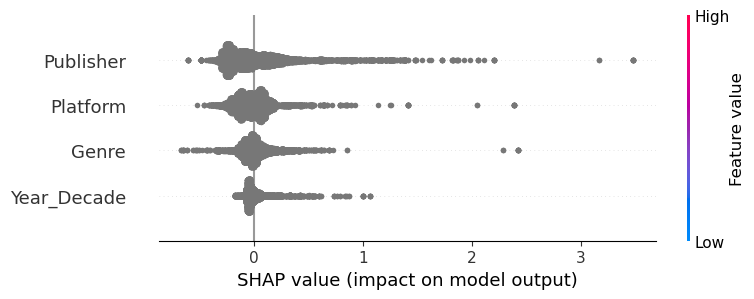

In [14]:
shap.initjs()
ex = shap.TreeExplainer(model)
shap_values = ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test, max_display=30)

In [15]:
expected_values = ex.expected_value
print(f"Average expected sales is {round(expected_values,3)} mln")
print(f"Average actual sales is {round(np.mean(y_test),3)} mln")

Average expected sales is 0.462 mln
Average actual sales is 0.465 mln



Platform



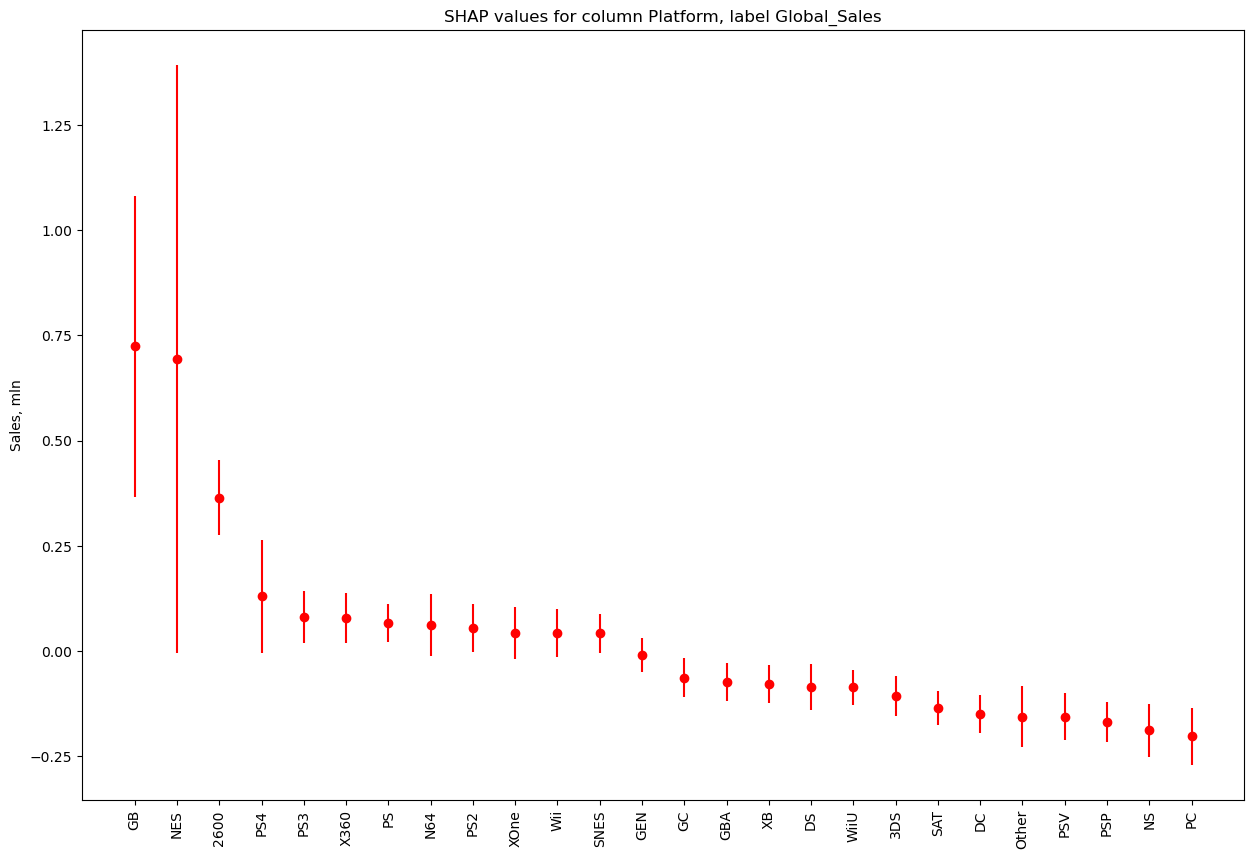

        gain  gain_std  count
col                          
GB     0.724     0.359     62
NES    0.694     0.700     69
2600   0.364     0.089    109
PS4    0.129     0.134    613
PS3    0.080     0.061   1190
X360   0.077     0.060   1087
PS     0.066     0.046    939
N64    0.061     0.074    211
PS2    0.054     0.057   1639
XOne   0.042     0.061    350
Wii    0.041     0.057   1195
SNES   0.041     0.047    165
GEN   -0.011     0.040     20
GC    -0.064     0.046    376
GBA   -0.074     0.045    652
XB    -0.080     0.045    591
DS    -0.086     0.055   1848
WiiU  -0.087     0.042    130
3DS   -0.108     0.048    480
SAT   -0.137     0.040    129
DC    -0.151     0.045     42
Other -0.157     0.072     39
PSV   -0.157     0.055    530
PSP   -0.170     0.047   1056
NS    -0.190     0.064    142
PC    -0.204     0.068   1094

Genre



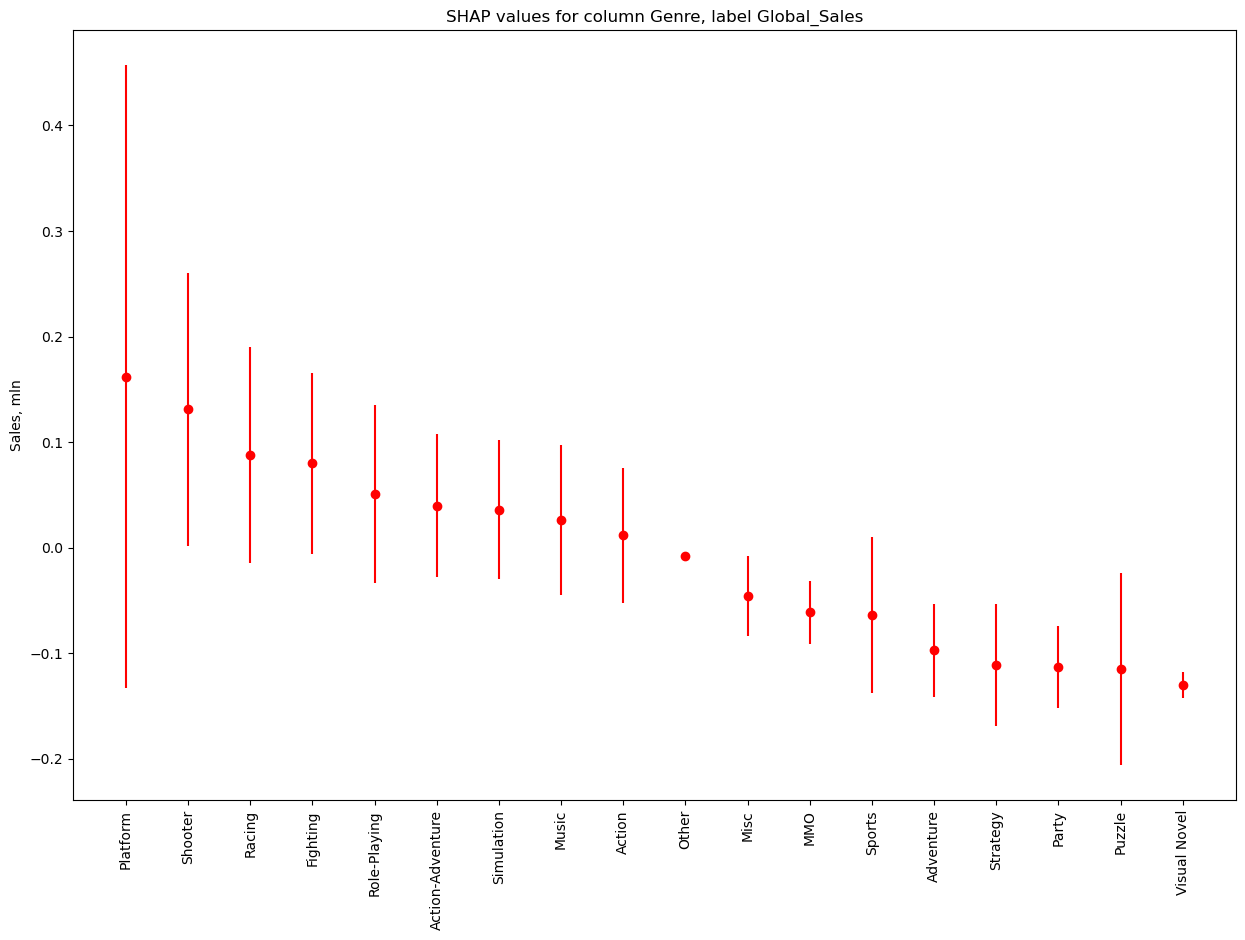

                   gain  gain_std  count
col                                     
Platform          0.162     0.295    725
Shooter           0.131     0.129   1162
Racing            0.088     0.102   1038
Fighting          0.080     0.086    686
Role-Playing      0.051     0.084   1309
Action-Adventure  0.040     0.068    128
Simulation        0.036     0.066    831
Music             0.026     0.071     93
Action            0.012     0.064   2584
Other            -0.008     0.000      2
Misc             -0.046     0.038   1528
MMO              -0.061     0.030     13
Sports           -0.064     0.074   2083
Adventure        -0.097     0.044   1293
Strategy         -0.111     0.058    630
Party            -0.113     0.039     10
Puzzle           -0.115     0.091    534
Visual Novel     -0.130     0.012    109

Publisher



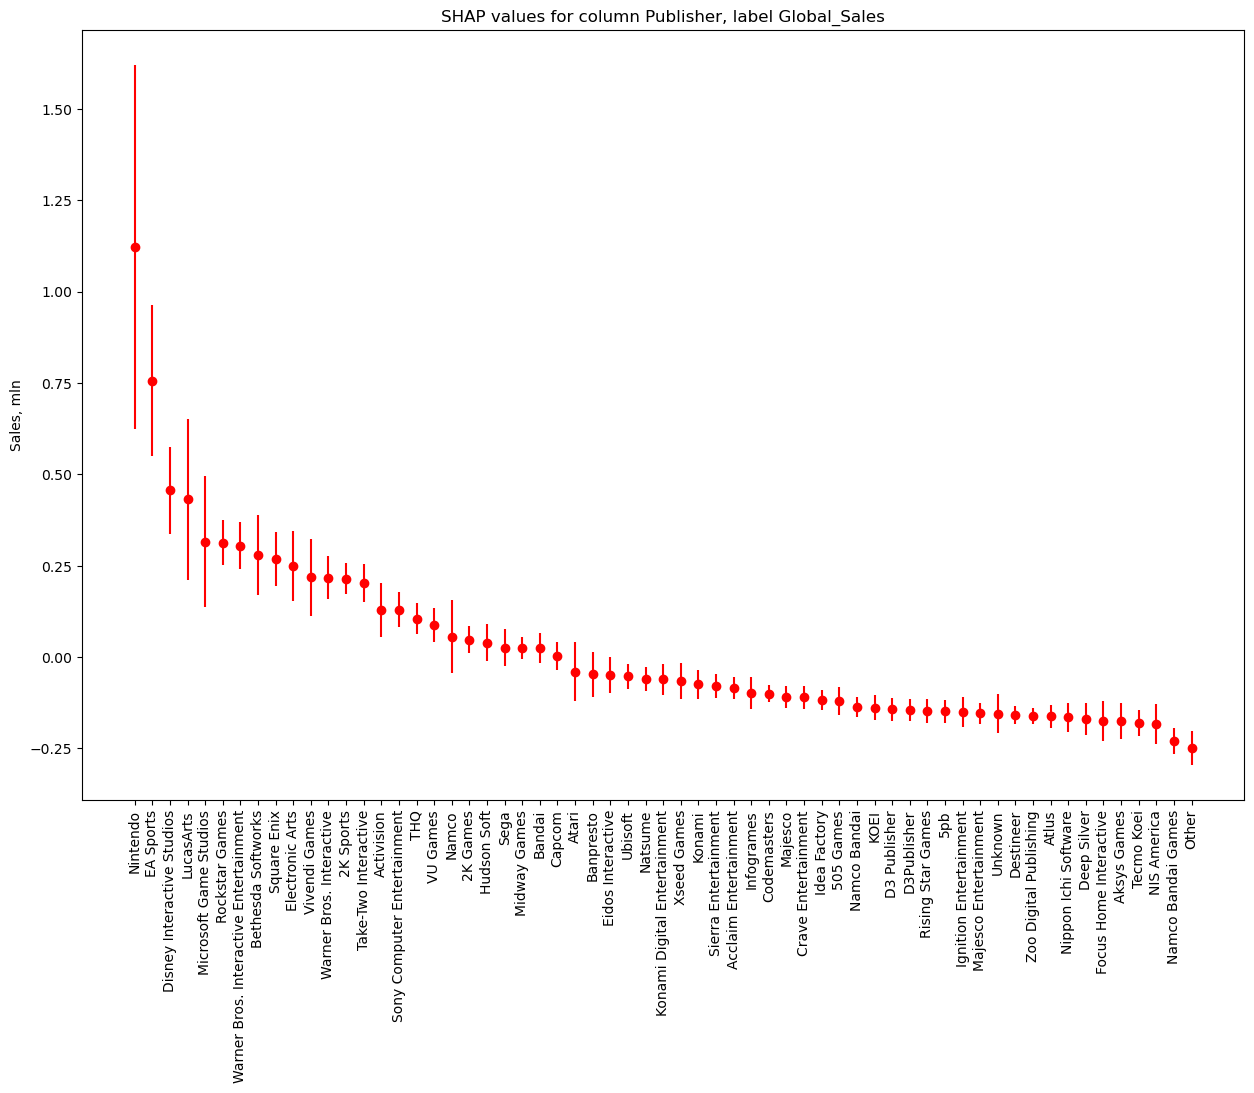

                                         gain  gain_std  count
col                                                           
Nintendo                                1.122     0.498    444
EA Sports                               0.756     0.207    272
Disney Interactive Studios              0.456     0.118    175
LucasArts                               0.432     0.220     92
Microsoft Game Studios                  0.315     0.179    107
Rockstar Games                          0.313     0.062     37
Warner Bros. Interactive Entertainment  0.305     0.064    182
Bethesda Softworks                      0.280     0.109     63
Square Enix                             0.268     0.073    197
Electronic Arts                         0.249     0.095    883
Vivendi Games                           0.218     0.105     92
Warner Bros. Interactive                0.217     0.059     74
2K Sports                               0.214     0.042     95
Take-Two Interactive                    0.202     0.052

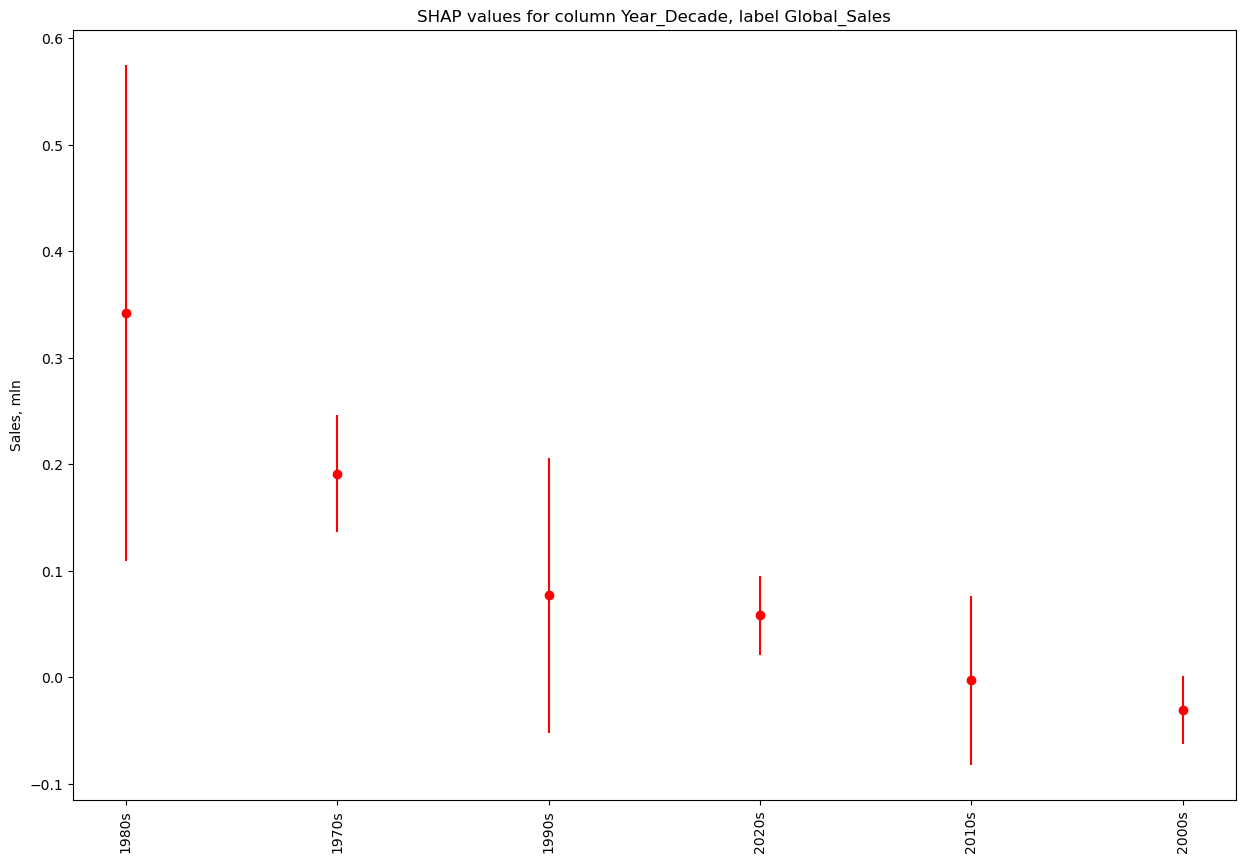

        gain  gain_std  count
col                          
1980s  0.342     0.233    164
1970s  0.191     0.055      5
1990s  0.077     0.129   1307
2020s  0.058     0.037     14
2010s -0.003     0.079   5576
2000s -0.031     0.032   7692


In [16]:
def show_shap(col, shap_values=shap_values, label=main_label, X_test=X_test, ylabel='Sales, mln'):
    df_infl = X_test.copy()
    df_infl['shap_'] = shap_values[:,df_infl.columns.tolist().index(col)]
    gain = round(df_infl.groupby(col).mean()['shap_'],3)
    gain_std = round(df_infl.groupby(col).std()['shap_'],3)
    cnt = df_infl.groupby(col).count()['shap_']
    dd_dict = {'col': list(gain.index), 'gain': list(gain.values), 'gain_std': list(gain_std.values), 'count': cnt}
    df_res = pd.DataFrame.from_dict(dd_dict).sort_values('gain', ascending=False).set_index('col')
    plt.figure(figsize=(15,10))
    plt.errorbar(df_res.index, df_res['gain'], yerr=df_res['gain_std'], fmt="o", color="r")
    plt.title(f'SHAP values for column {col}, label {label}')
    plt.ylabel(ylabel)
    plt.tick_params(axis="x", rotation=90)
    plt.show();
    print(df_res)
    return

for col in X_test.columns:
    print()
    print(col)
    print()
    show_shap(col, shap_values, label=main_label, X_test=X_test)